# Convolution Deep Leraning Network - CIFS 100 




In [1]:

%pip install -q keras-tuner numpy imageio pydot tensorflow-gpu == 2.9.1 keras


ERROR: Invalid requirement: '-'
Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.datasets.cifar100


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2022-06-04 11:56:18.157161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 11:56:18.178899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 11:56:18.179053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


## Setup and DataSet

In [5]:

EPOCH = 120
BUFFER_SIZE = 192
BATCH_SIZE = 64


In [6]:

def loadDataCifar100():
    (train_images, train_labels), (test_images,
                                   test_labels) = tensorflow.keras.datasets.cifar100.load_data(label_mode='fine'
                                                                                               )

    class_names = [
        "apple",
        "aquarium_fish",
        "baby",
        "bear",
        "beaver",
        "bed",
        "bee",
        "beetle",
        "bicycle",
        "bottle",
        "bowl",
        "boy",
        "bridge",
        "bus",
        "butterfly",
        "camel",
        "can",
        "castle",
        "caterpillar",
        "cattle",
        "chair",
        "chimpanzee",
        "clock",
        "cloud",
        "cockroach",
        "couch",
        "crab",
        "crocodile",
        "cup",
        "dinosaur",
        "dolphin",
        "elephant",
        "flatfish",
        "forest",
        "fox",
        "girl",
        "hamster",
        "house",
        "kangaroo",
        "keyboard",
        "lamp",
        "lawn_mower",
        "leopard",
        "lion",
        "lizard",
        "lobster",
        "man",
        "maple_tree",
        "motorcycle",
        "mountain",
        "mouse",
        "mushroom",
        "oak_tree",
        "orange",
        "orchid",
        "otter",
        "palm_tree",
        "pear",
        "pickup_truck",
        "pine_tree",
        "plain",
        "plate",
        "poppy",
        "porcupine",
        "possum",
        "rabbit",
        "raccoon",
        "ray",
        "road",
        "rocket",
        "rose",
        "sea",
        "seal",
        "shark",
        "shrew",
        "skunk",
        "skyscraper",
        "snail",
        "snake",
        "spider",
        "squirrel",
        "streetcar",
        "sunflower",
        "sweet_pepper",
        "table",
        "tank",
        "telephone",
        "television",
        "tiger",
        "tractor",
        "train",
        "trout",
        "tulip",
        "turtle",
        "wardrobe",
        "whale",
        "willow_tree",
        "wolf",
        "woman",
        "worm"]

    TrainX = np.concatenate((train_images, test_images))
    TrainY = np.squeeze(np.concatenate((train_labels, test_labels)))

    TrainX = TrainX / 255.0

    return TrainX, TrainY, class_names


#

In [7]:
trainX, trainY, classes = loadDataCifar100()
IMAGE_SIZE = trainX[0].shape
BATCH_SIZE = 256
EPOCH = 96


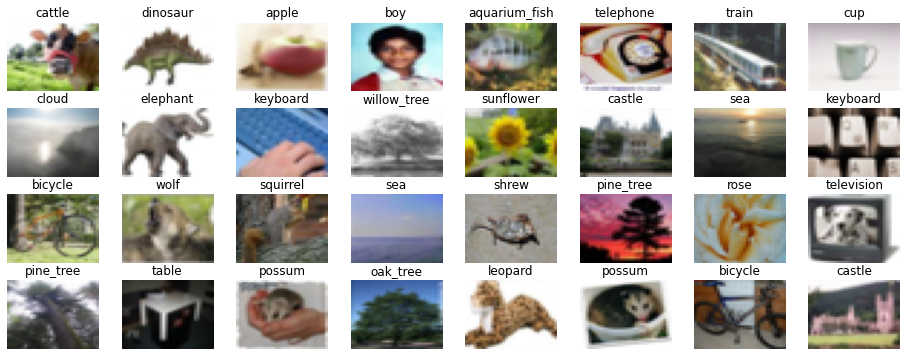

In [8]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8 
for index, (image, label) in enumerate(zip(trainX[0:nrImage], trainY[0:nrImage])):
    plt.subplot(4, 8, (index + 1))
    plt.title(label=str.format("{0}", classes[label]))

    plt.imshow(X=image, cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


In [9]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


## Create Network with Hyperparameter
By using hyperparameter, a set of possible neuron network configuration can be setup. This allows to find the neuron that are most optimal.

In [10]:

def generate_cnn_builder(hp, input, output):
    cnn_model = tf.keras.Sequential()
    #
    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    hp_kernel_filter_size_l0 = hp.Int(
        'kernel_filter_size_0', min_value=16, max_value=192, step=16)
    hp_kernel_filter_size_l1 = hp.Int(
        'kernel_filter_size_1', min_value=16, max_value=192, step=16)

    hp_strides_size_l0 = hp.Int(
        'hp_strides_size_l0', min_value=1, max_value=2, step=1)
    hp_strides_size_l1 = hp.Int(
        'hp_strides_size_l1', min_value=1, max_value=2, step=1)

    hp_kernel_size_l0 = hp.Int(
        'hp_kernel_size_l0', min_value=3, max_value=7, step=2)
    hp_kernel_size_l1 = hp.Int(
        'hp_kernel_size_l1', min_value=3, max_value=7, step=2)

    hp_max_pooling_size_l0 = hp.Int(
        'max_pooling_l0', min_value=1, max_value=3, step=1)
    hp_max_pooling_size_l1 = hp.Int(
        'max_pooling_l1', min_value=1, max_value=3, step=1)

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l0, kernel_size=(3, 3), strides=hp_strides_size_l0,
                      kernel_initializer=kernel_init, activation='relu',
                      padding='same',
                      input_shape=input))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l0))

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l1, kernel_size=(3, 3), strides=hp_strides_size_l1,
                      activation='relu', kernel_initializer=kernel_init))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l1))

    cnn_model.add(layers.Flatten())

    hp_units = hp.Int('dense0_units', min_value=32, max_value=512, step=32)
    cnn_model.add(layers.Dense(units=hp_units, kernel_initializer=kernel_init))
    cnn_model.add(layers.Dense(units=output))

    cnn_model.summary()

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=keras.losses.SparseCategoricalCrossentropy(
                          from_logits=True),
                      metrics=['accuracy'])

    return cnn_model


In [11]:
# Neuron network input and output.
image_shape = trainX[0].shape
num_classes_output = len(classes)

train_X, test_X, train_y, test_y = train_test_split(
    trainX, trainY, shuffle=True, test_size=0.25)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  ' + str(test_X.shape))
print('Y_test:  ' + str(test_y.shape))

def model_builder(hp):
    model = generate_cnn_builder(hp, image_shape, num_classes_output)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='cache',
                     project_name=str.format('cnn - {0}', "cifs-100"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_X, train_y, validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE,
             callbacks=[stop_early],verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)


Trial 30 Complete [00h 00m 08s]
val_accuracy: 0.16555555164813995

Best val_accuracy So Far: 0.3655555546283722
Total elapsed time: 00h 04m 18s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 144)         166032    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 144)        0         
 2D)                                                             
                                                                 
 flatt

In [12]:
cnn_model = tuner.hypermodel.build(best_hps)
cnn_model.summary()
cnn_model_history = cnn_model.fit(train_X, train_y, epochs=EPOCH)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 144)         166032    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 144)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1296)              0         
                                                                 
 dense_2 (Dense)             (None, 160)              

In [13]:
val_acc_per_epoch = cnn_model_history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: {0}'.format(best_epoch,))

cnn_model.evaluate(test_X, test_y, verbose=2)

cnn_model.summary()


Best epoch: 94
469/469 - 1s - loss: 7.5611 - accuracy: 0.3193 - 547ms/epoch - 1ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 144)         166032    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 144)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1296)              0         
                                 

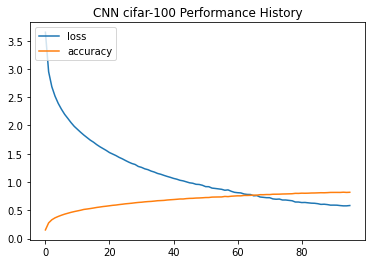

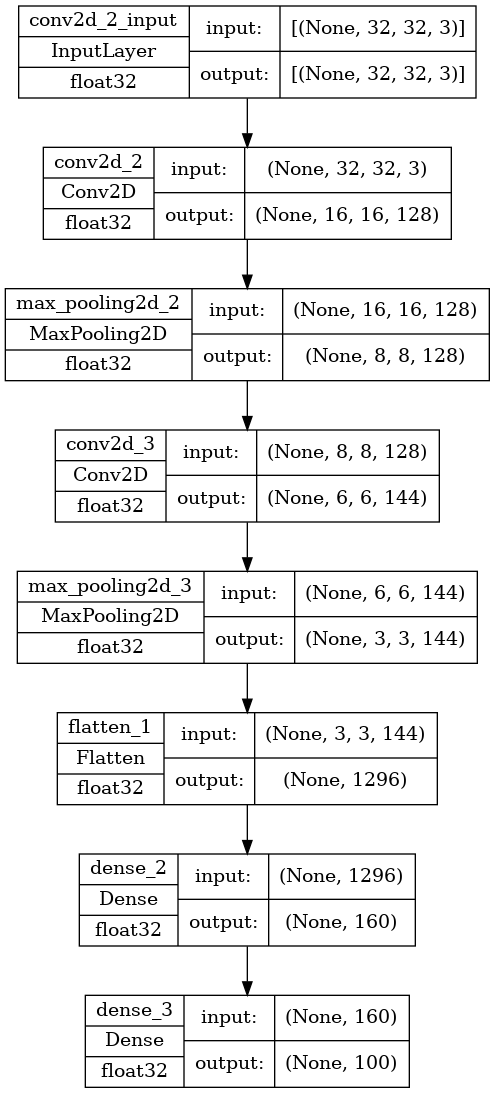

<Figure size 432x288 with 0 Axes>

In [14]:
plotCostHistory(cnn_model_history.history, title=str.format(
    "CNN {0} Performance History", "cifar-100"))

tf.keras.utils.plot_model(
    cnn_model, to_file=str.format('cnn_{0}_model.png', "cifar-100"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)


In [ ]:
cnn_model.save(str.format("cnn_{0}.h5", "cifar-100"))